# DATA VISUALIZATION

### Import necessary packages

In [1]:
import rasterio
from rasterio.windows import Window

import matplotlib.pyplot as plt
import numpy as np

from skimage.exposure import rescale_intensity
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Utility to visualize properly Sentinel-2 images

In [2]:
def sentinel2_realcolor(image):
    image = image[2::-1]/1000 # magnification
    return rescale_intensity(
        image,
        in_range=(
            np.quantile(image, 0.01),
            np.quantile(image, 0.99),
        ),
    )

### Location of the images

In [3]:
raster_dirs = {
    'orthophoto': '/CatLC/ORTHO/ORTHO_CAT_2018_UTM_WGS84_31N_1m.tif',
    'orthophotoIR': '/CatLCN/ORTHO/ORTHOIR_CAT_2018.tif',
    
    'sentinel1': '/CatLCN/S1/S1_CAT_GRD_ASC_VV_2018_UTM_WGS84_31N_10m.tif',
    
    'sentinel2april': '/CatLCN/S2/S2_CAT_201804_UTM_WGS84_31N_10m.tif',
    'sentinel2august': '/CatLCN/S2/S2_CAT_201808_UTM_WGS84_31N_10m.tif',
    
    'aspect': '/CatLCN/DEM/ASPECT_CAT_UTM_WGS84_31N_5m.tif',
    'dem': '/CatLCN/DEM/DEM_CAT_UTM_WGS84_31N_5m.tif',
    'slope': '/CatLCN/DEM/SLOPE_CAT_UTM_WGS84_31N_5m.tif',
    'dsm': '/CatLCN/DEM/DSM_CAT_1m_2018_v1.tif',    
    'chm': '/CatLCN/DEM/CHM_CAT_1m_2018_v1.tif',
    
    'landcover': '/CatLCN/LC/LC_2018_UTM_WGS84_31N_1m.tif',
}

### List of all tiles of size 960x960 (without pixel repetition) that don't contain any pixel from outside the borders

In [4]:
no_borders = np.load('/utils/no_borders_960.npy', allow_pickle=True)

### Colormap and boundaries to plot correctly the landcover (groundtruth)

In [5]:
with open('/utils/cmap_mcsc.pickle', 'rb') as f:
    cmap_mcsc = np.load(f, allow_pickle=True)
with open('/utils/norm_mcsc.pickle', 'rb') as f:
    norm_mcsc = np.load(f, allow_pickle=True)

### Visualization of all the images

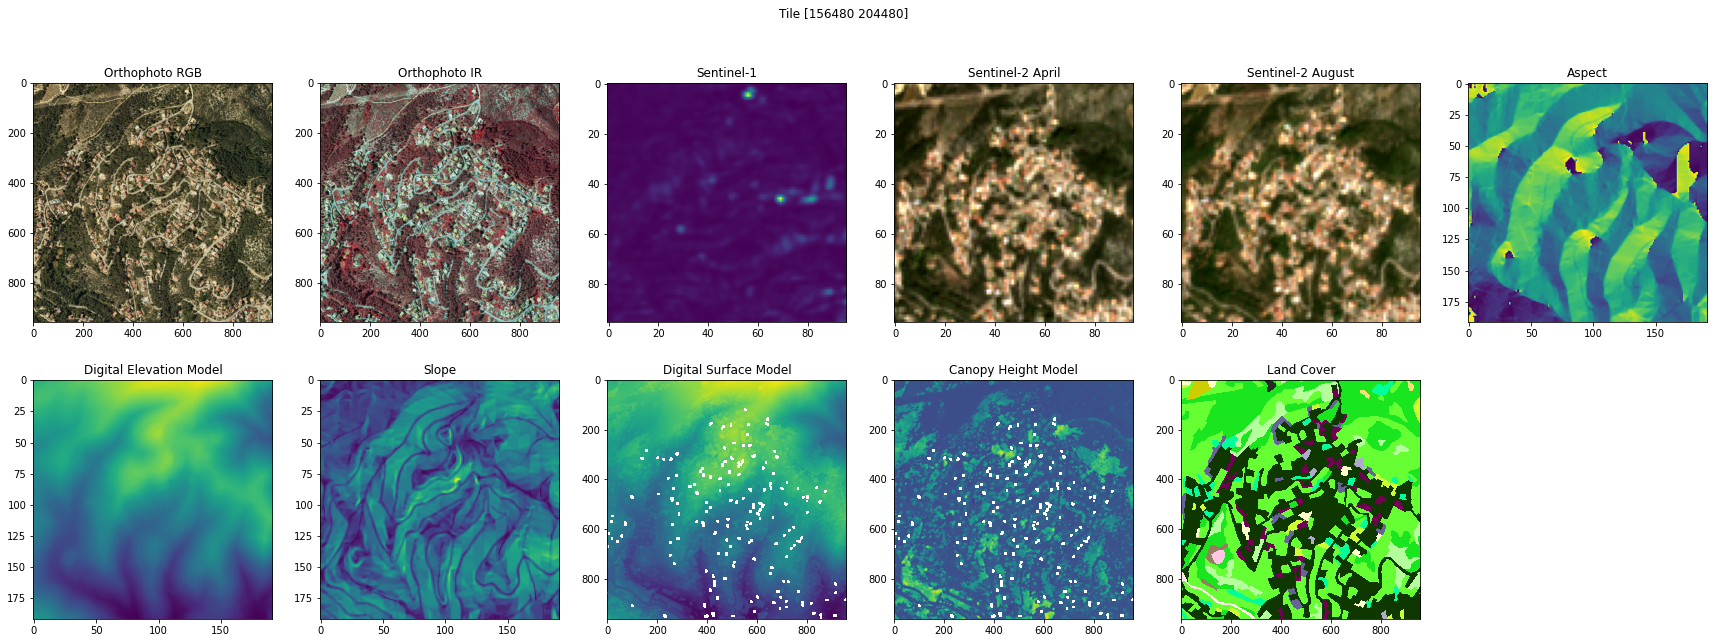

In [6]:
tile = np.array([156480, 204480]) # tile = random.choice(no_borders)
fig, axs = plt.subplots(2,6, figsize=(30,10))

fig.suptitle(f'Tile {tile}')

axs = axs.flatten()
window = Window(*tile, 960, 960)
with rasterio.open(raster_dirs['orthophoto']) as src:
    pic = src.read(window=window)
pic0 = np.moveaxis(pic, 0, -1)
axs[0].imshow(pic0)
axs[0].set_title('Orthophoto RGB')

with rasterio.open(raster_dirs['orthophotoIR']) as src:
    pic = src.read(window=window)
pic = np.moveaxis(pic, 0, -1)
pic = np.concatenate((pic[...,0:1], pic0[...,0:2]), axis=-1)
axs[1].imshow(pic)
axs[1].set_title('Orthophoto IR')

window = Window(*tile // 10, 96, 96)
with rasterio.open(raster_dirs['sentinel1']) as src:
    pic = src.read(1, window=window)
pic = np.moveaxis(pic, 0, -1)
axs[2].imshow(pic)
axs[2].set_title('Sentinel-1')

with rasterio.open(raster_dirs['sentinel2april']) as src:
    pic = src.read([1,2,3], window=window)
pic = sentinel2_realcolor(pic)
pic = np.moveaxis(pic, 0, -1)
axs[3].imshow(pic)
axs[3].set_title('Sentinel-2 April')

with rasterio.open(raster_dirs['sentinel2august']) as src:
    pic = src.read([1,2,3], window=window)
pic = sentinel2_realcolor(pic)
pic = np.moveaxis(pic, 0, -1)
axs[4].imshow(pic)
axs[4].set_title('Sentinel-2 August')

window = Window(*tile // 5, 192, 192)
with rasterio.open(raster_dirs['aspect']) as src:
    pic = src.read(window=window)
pic[pic == -9999] = np.nan
pic = np.moveaxis(pic, 0, -1)
axs[5].imshow(pic)
axs[5].set_title('Aspect')

with rasterio.open(raster_dirs['dem']) as src:
    pic = src.read(window=window)
pic[pic == -9999] = np.nan
pic = np.moveaxis(pic, 0, -1)
axs[6].imshow(pic)
axs[6].set_title('Digital Elevation Model')

with rasterio.open(raster_dirs['slope']) as src:
    pic = src.read(window=window)
pic[pic == -9999] = np.nan
pic = np.moveaxis(pic, 0, -1)
axs[7].imshow(pic)
axs[7].set_title('Slope')


window = Window(*tile, 960, 960)
with rasterio.open(raster_dirs['dsm']) as src:
    pic = src.read(window=window)
pic[pic == -9999] = np.nan
pic = np.moveaxis(pic, 0, -1)
axs[8].imshow(pic)
axs[8].set_title('Digital Surface Model')


with rasterio.open(raster_dirs['chm']) as src:
    pic = src.read(window=window)
pic[pic == -9999] = np.nan
pic = np.moveaxis(pic, 0, -1)
axs[9].imshow(pic)
axs[9].set_title('Canopy Height Model')

with rasterio.open(raster_dirs['landcover']) as src:
    pic = src.read(window=window)
pic = np.moveaxis(pic, 0, -1)
axs[10].imshow(pic, cmap=cmap_mcsc, norm=norm_mcsc, interpolation='none')
axs[10].set_title('Land Cover')

axs[11].axis('off')

plt.show()

# Data preparation to train a neural network

### Convert numpy arrays into torch tensors

In [7]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        tile, orthophoto, orthophotoIR, chm, sentinel2april, sentinel2august, landcover = \
        sample['tile'], sample['orthophoto'], sample['orthophotoIR'], sample['chm'], \
        sample['sentinel2april'], sample['sentinel2august'], sample['landcover']
        
        orthophoto = orthophoto.astype(np.float32)
        orthophotoIR = orthophotoIR.astype(np.float32)
        chm = chm.astype(np.float32)
        sentinel2april = sentinel2april.astype(np.float32)
        sentinel2august = sentinel2august.astype(np.float32)
        
        return {
            'tile': tile,
            'orthophoto': torch.from_numpy(orthophoto), 'orthophotoIR': torch.from_numpy(orthophotoIR),
            'chm': torch.from_numpy(chm),
            'sentinel2april': torch.from_numpy(sentinel2april), 'sentinel2august': torch.from_numpy(sentinel2august),
            'landcover': torch.from_numpy(landcover-1) # -1 to start in class 0, dataset starts in class 1
        }

It would be also interesting to create a new transformation in order to normalize the tensors.

We create the dataset with the desired shape for each tile. In this case we have some images of 1m and 10m resolution. We could also more images from the dataset.

In [8]:
class CatalanDataset(Dataset):
    def __init__(self, tiles_list, raster_dirs, shape=960, transform=None):
        self.tiles_list = tiles_list
        self.raster_dirs = raster_dirs
        self.transform = transform
        self.shape = shape

    def __len__(self):
        return len(self.tiles_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
            
        window_1m = Window(*self.tiles_list[idx], self.shape, self.shape)
        
        with rasterio.open(self.raster_dirs['orthophoto']) as src:
            raster_orthophoto = src.read(window=window_1m) # (3, shape, shape) uint8
            
        with rasterio.open(self.raster_dirs['orthophotoIR']) as src:
            raster_orthophotoIR = src.read(window=window_1m) # (3, shape, shape) uint8
        
        with rasterio.open(self.raster_dirs['landcover']) as src:
            raster_landcover = src.read(window=window_1m) # (1,shape,shape) uint8
            
        window_10m = Window(*self.tiles_list[idx] // 10, self.shape//10, self.shape//10)
            
        with rasterio.open(self.raster_dirs['sentinel2april']) as src:
            raster_sentinel2april = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m) # (10,shape,shape) uint16
            
        with rasterio.open(self.raster_dirs['sentinel2april']) as src:
            raster_sentinel2august = src.read([1,2,3,4,5,6,7,8,9,10], window=window_10m) # (10,shape,shape) uint16
            
        with rasterio.open(self.raster_dirs['chm']) as src:
            raster_chm = src.read(window=window_10m)  # (1,shape,shape) float32
            
        sample = {
            'tile': idx, 'orthophoto': raster_orthophoto, 'orthophotoIR': raster_orthophotoIR,
            'chm': raster_chm, 'sentinel2april': raster_sentinel2april,
            'sentinel2august': raster_sentinel2august,'landcover': raster_landcover
        }
        

        if self.transform:
            sample = self.transform(sample)

        return sample

In [9]:
catalan_dataset_train = CatalanDataset(no_borders, raster_dirs, transform=transforms.Compose([ToTensor()]))

Dataloader used to train in paralel as much tiles as wanted. It is recommended to increase num_workers to speed up the process.

In [10]:
train_loader = DataLoader(catalan_dataset_train, batch_size=2, shuffle=True, num_workers=1)

In [11]:
data = next(iter(train_loader))